In [48]:
pwd

'/ai-data/neuro/data/restored/patch/model_torch_valid'

In [49]:
cd /ai-data/neuro/data/restored/patch/model_torch_valid

/ai-data/neuro/data/restored/patch/model_torch_valid


In [50]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import affine_transform
from scipy.ndimage import rotate
from numpy.linalg import norm

In [51]:
# set the path to the npz file
file_path = 'HHHHH_CA_000034.npz'

# load the npz file
npz_data = np.load(file_path)

# print the keys in the npz file
print("Keys in the npz file:", npz_data.files)

keys_to_print = ['center', 'direction', 'data', 'mask', 'intersection_over_aneurysm']

for key in keys_to_print:
    if key in npz_data:
        shape = npz_data[key].shape
        print(f"Shape of {key}: {shape}")
    else:
        print(f"{key} not found in the npz file.")

Keys in the npz file: ['center', 'direction', 'data', 'mask', 'data_normed', 'data_upscaled', 'mask_upscaled', 'intersection_over_aneurysm']
Shape of center: (900, 3)
Shape of direction: (900, 9)


Shape of data: (900, 32, 32, 32)
Shape of mask: (900, 32, 32, 32)
Shape of intersection_over_aneurysm: (900, 1)


In [52]:
index =742
data = npz_data['data'][index]
mask = npz_data['mask'][index]
direction = npz_data['direction'][index]
center = npz_data['center'][index]
intersection_over_aneurysm = npz_data['intersection_over_aneurysm'][index]

In [53]:
print("direction : ", direction)
print("center : ", center)
print("intersection_over_aneurysm : ", intersection_over_aneurysm)

direction :  [ 0.11221423 -0.73946417  0.66377761  0.93609733 -0.1454332  -0.32026703
  0.33336129  0.65729897  0.67589076]
center :  [ -5.51638215 -47.03119421   4.14160815]
intersection_over_aneurysm :  [1.]


In [54]:
# Visualizing the data for all slices
def show_all_slices(data):
    num_slices = data.shape[0]
    cols = 8  
    rows = num_slices // cols + int(num_slices % cols != 0)

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.flatten()

    for i in range(num_slices):
        axes[i].imshow(data[i, :, :], cmap='gray')
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')
 
    for i in range(num_slices, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizing the overlay of the mask on the data for all slices
def show_all_slices_with_overlay(data, mask):
    num_slices = data.shape[0]
    cols = 8  
    rows = num_slices // cols + int(num_slices % cols != 0)

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.flatten()

    for i in range(num_slices):
        axes[i].imshow(data[i, :, :], cmap='gray', interpolation='none')
        axes[i].imshow(mask[i, :, :], cmap='hot', alpha=0.5, interpolation='none')  # Overlay mask
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')
        
    for i in range(num_slices, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

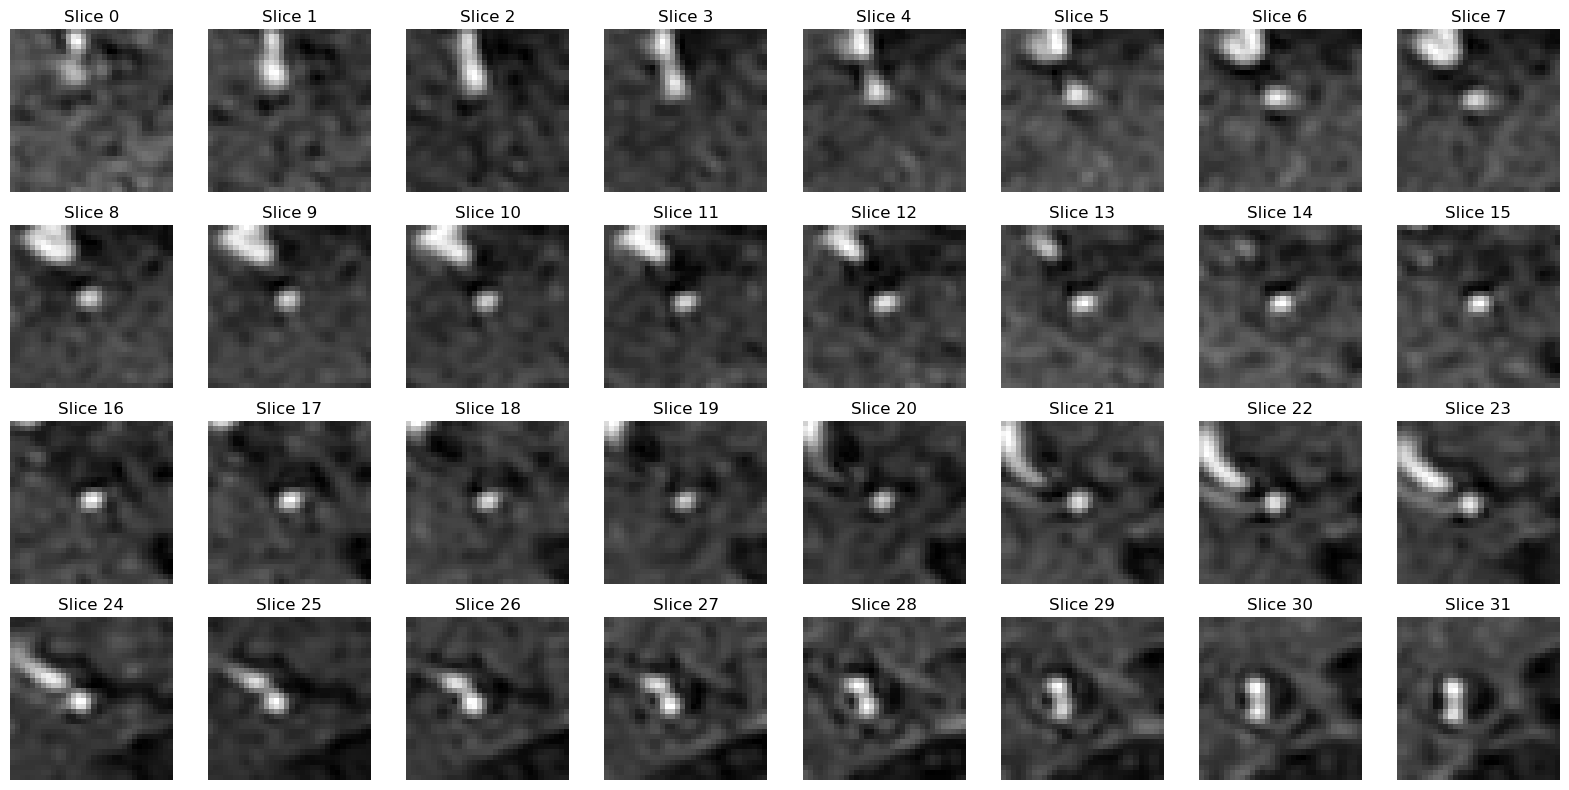

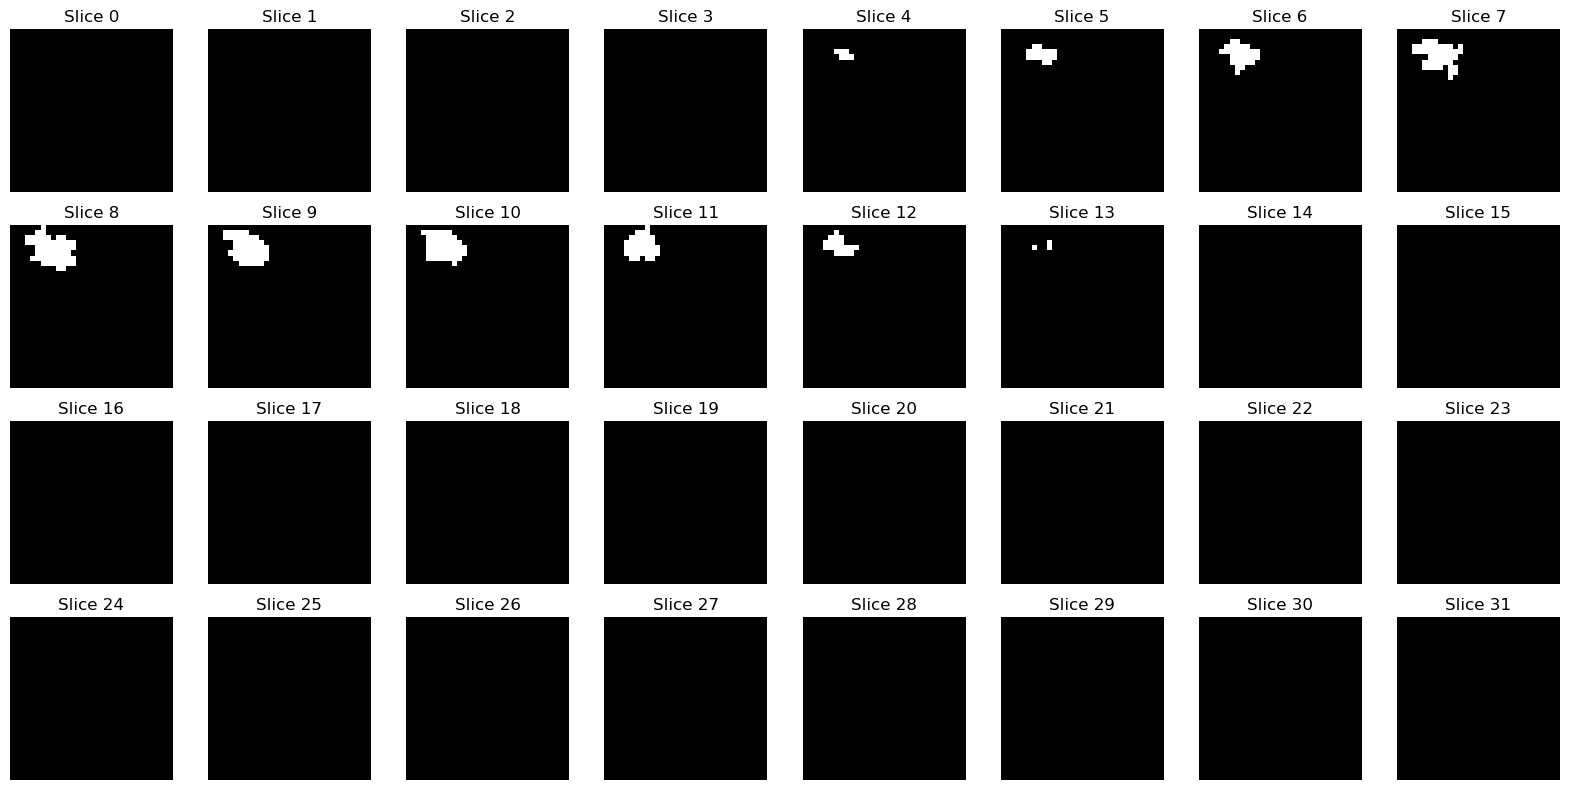

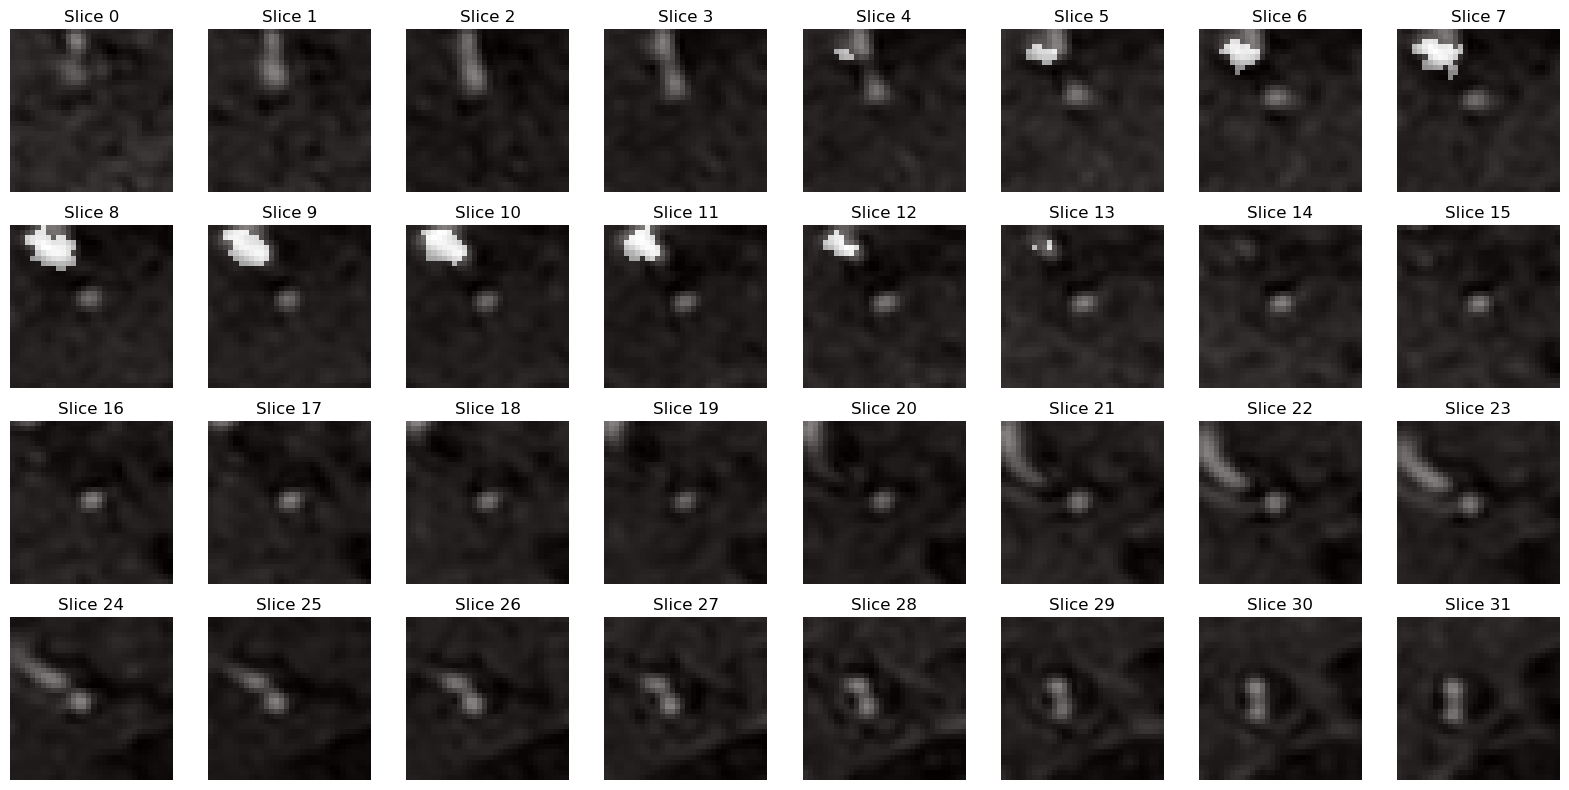

In [55]:
show_all_slices(data)
show_all_slices(mask)
show_all_slices_with_overlay(data, mask)

In [56]:
def overlay_slices(data, mask, process_all_slices=True, average_slices=False):
    """
    Creates overlay images from given data and mask slices, with an option to average the overlays.
    
    Args:
    data (numpy.ndarray): The 3D array of data slices.
    mask (numpy.ndarray): The 3D array of mask slices.
    process_all_slices (bool): If True, processes all slices. If False, processes only slices where mask is 1.
    average_slices (bool): If True, averages the overlayed data and mask.
    
    Returns:
    tuple: A tuple containing overlayed data, overlayed mask, and overlayed data on mask.
           If average_slices is True, the data and mask are averaged.
    """
    overlayed_data = np.zeros_like(data[0])
    overlayed_mask = np.zeros_like(mask[0])

    # Determine which slices to process
    slice_indices = range(data.shape[0]) if process_all_slices else [i for i in range(data.shape[0]) if np.any(mask[i] == 1)]
    num_slices = len(slice_indices)

    # Overlay the slices
    for slice_index in slice_indices:
        overlayed_data += data[slice_index]
        overlayed_mask += mask[slice_index]

    if average_slices:
        # Calculate the average if required
        overlayed_data = overlayed_data / num_slices
        overlayed_mask = overlayed_mask / num_slices

    # Overlay the data on the mask
    overlayed_data_on_mask = np.where(overlayed_mask > 0, overlayed_data, 0)

    return overlayed_data, overlayed_mask, overlayed_data_on_mask

def visualize_overlay(overlayed_data, overlayed_mask, overlayed_data_on_mask):
    """
    Visualizes the overlayed images.
    
    Args:
    overlayed_data (numpy.ndarray): Overlayed data array.
    overlayed_mask (numpy.ndarray): Overlayed mask array.
    overlayed_data_on_mask (numpy.ndarray): Overlayed data on mask array.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
    axes[0].imshow(overlayed_data, cmap='gray')
    axes[0].set_title("Overlayed Data")

    axes[1].imshow(overlayed_mask, cmap='gray')
    axes[1].set_title("Overlayed Mask")

    axes[2].imshow(overlayed_data, cmap='gray', interpolation='none')
    axes[2].imshow(overlayed_mask, cmap='hot', alpha=0.5, interpolation='none')
    axes[2].set_title("Overlayed Data on Mask")

    plt.show()

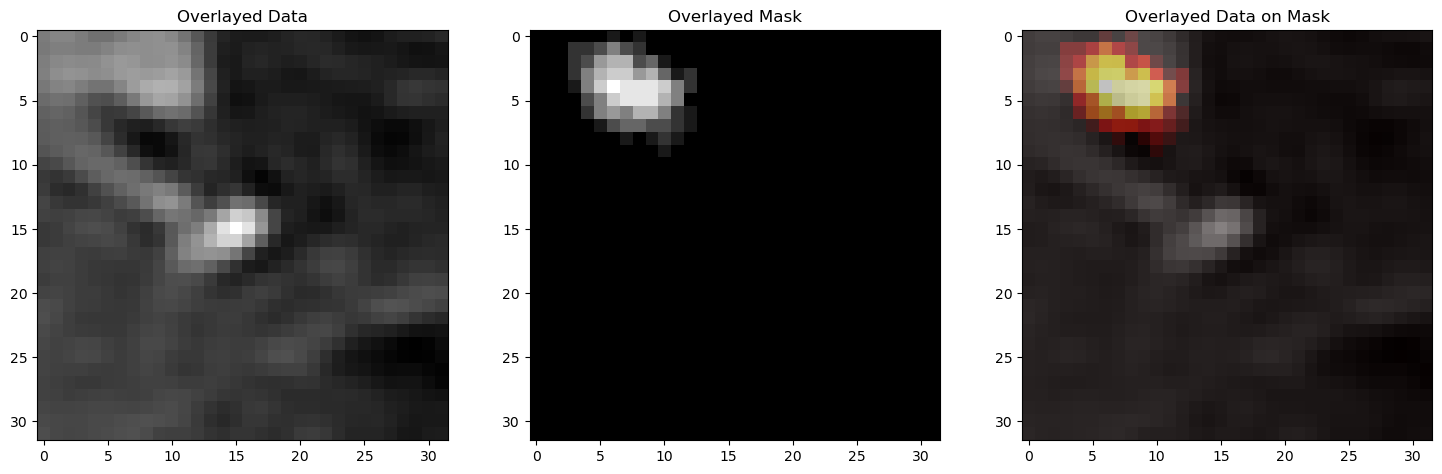

In [57]:
# overlayed data, mask, and data on mask
overlayed_data, overlayed_mask, overlayed_data_on_mask = overlay_slices(data, mask, process_all_slices=True, average_slices=False)
visualize_overlay(overlayed_data, overlayed_mask, overlayed_data_on_mask)

In [58]:
# rotate 90 degrees around the z axis
rotated_data = rotate(data, 90, axes=(0, 1), reshape=False)
rotated_mask = rotate(mask, 90, axes=(0, 1), reshape=False)

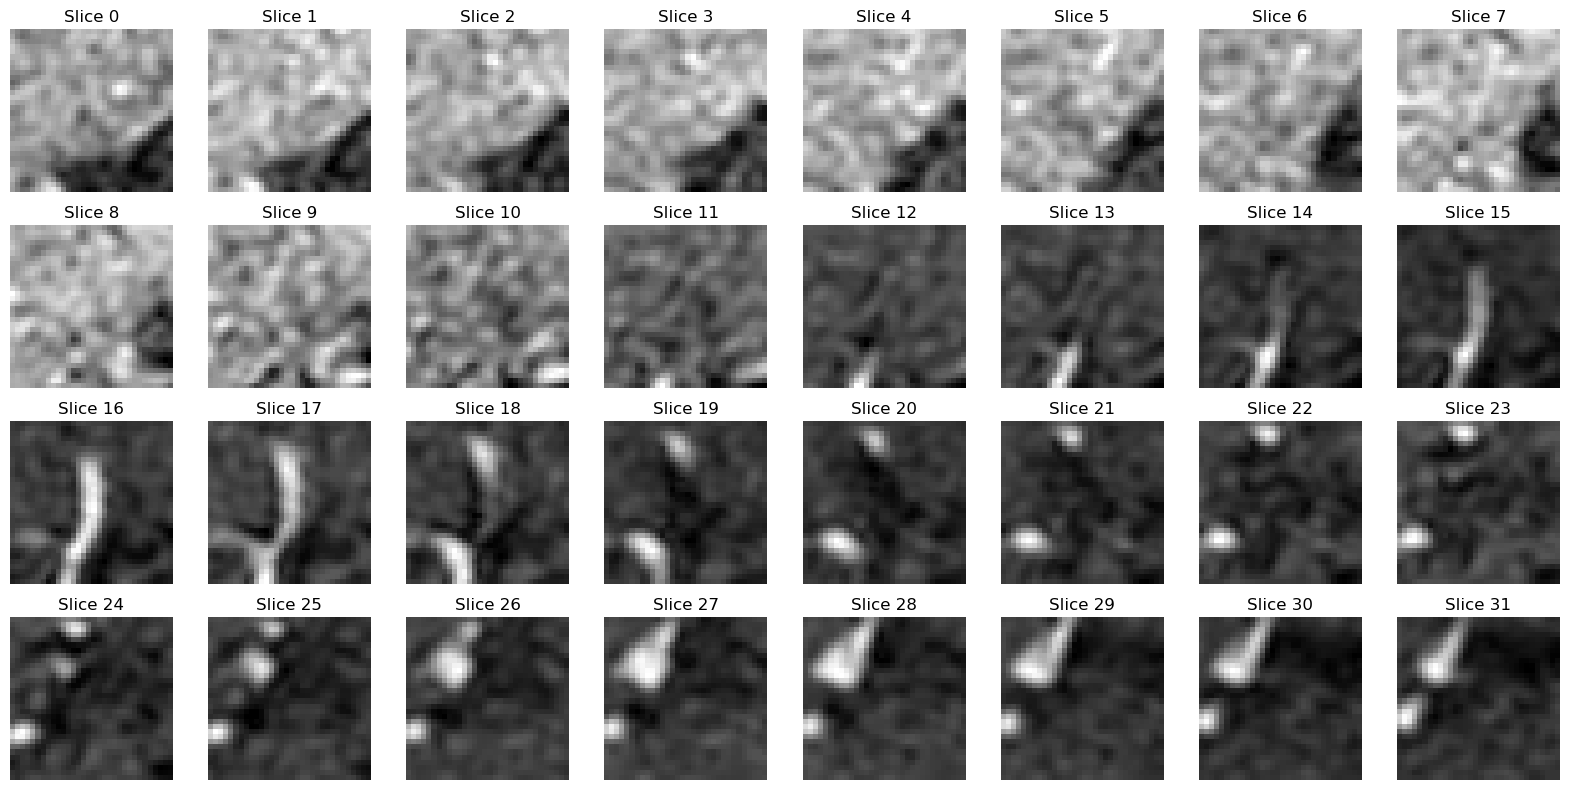

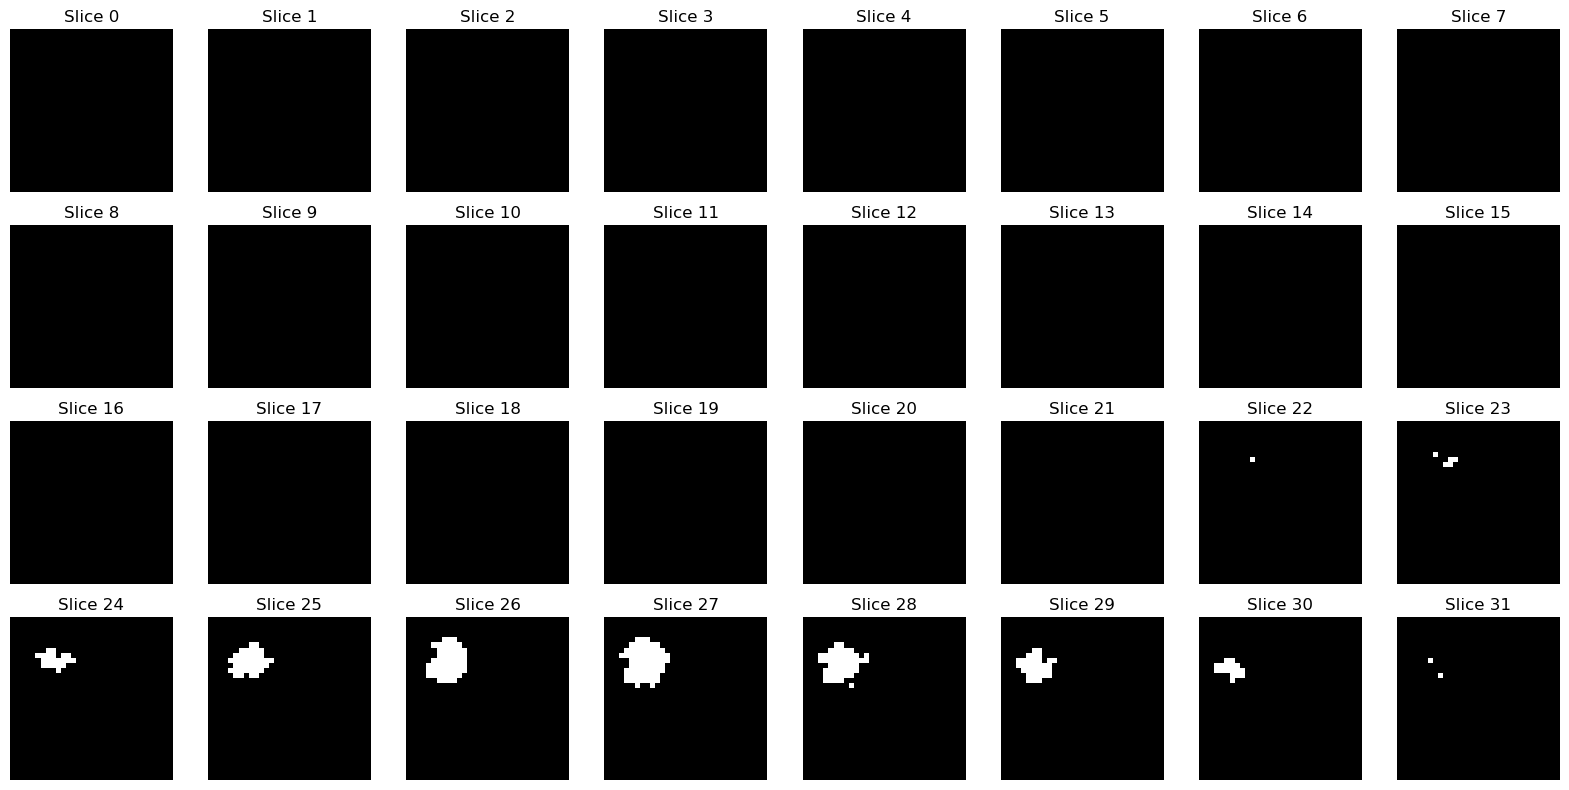

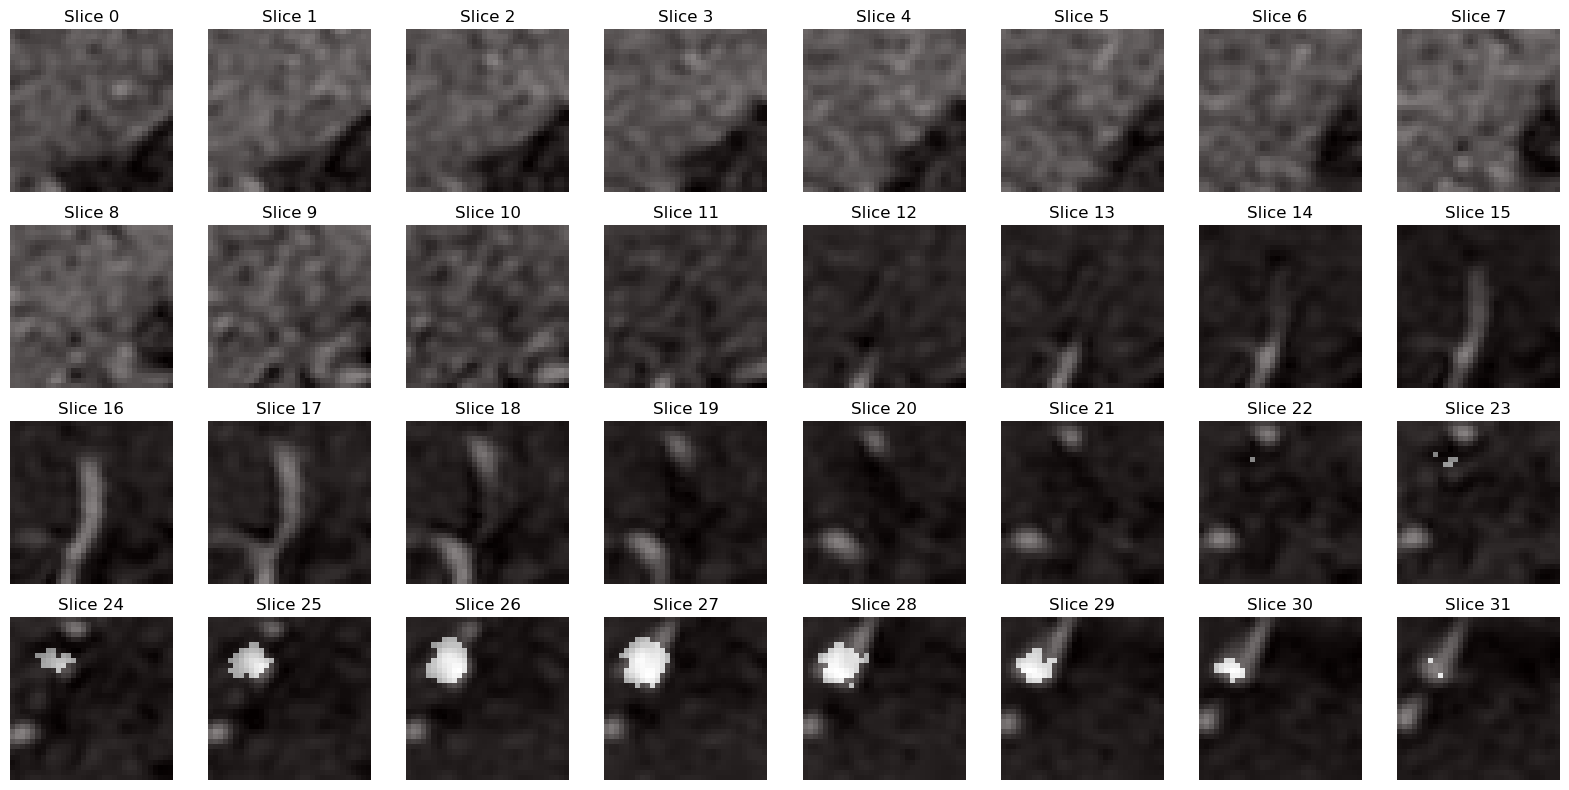

In [59]:
show_all_slices(rotated_data)
show_all_slices(rotated_mask)
show_all_slices_with_overlay(rotated_data, rotated_mask)

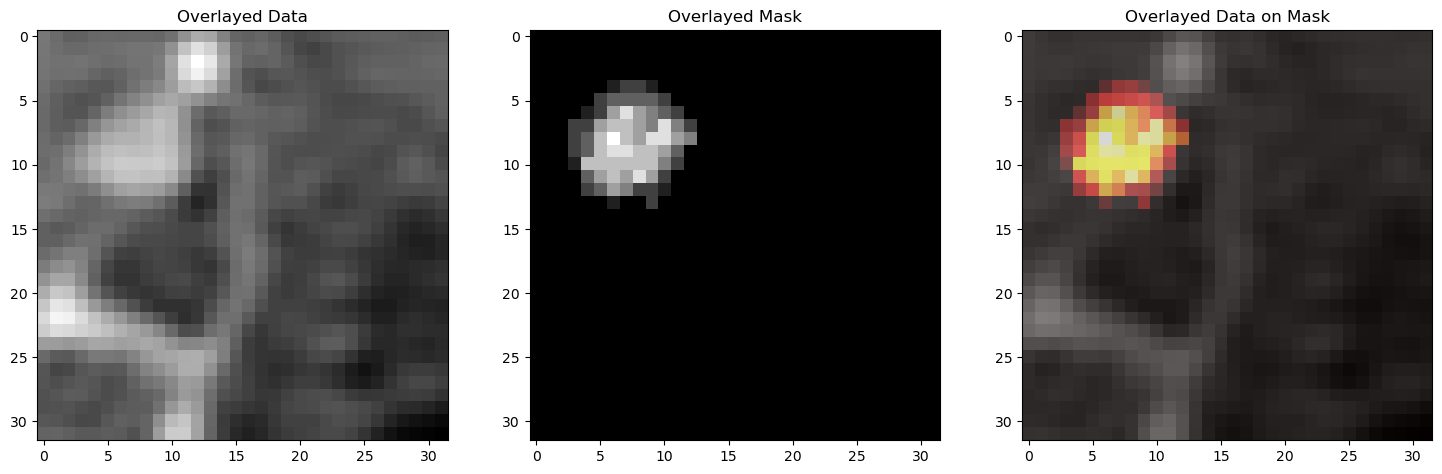

In [60]:
# overlayed rotated data, mask, and data on mask
overlayed_rotated_data, overlayed_rotated_mask, overlayed_rotated_data_on_mask = overlay_slices(rotated_data, rotated_mask, process_all_slices=True, average_slices=False)
visualize_overlay(overlayed_rotated_data, overlayed_rotated_mask, overlayed_rotated_data_on_mask)

In [61]:
# rotation matrix that rotates 90 degrees around the z axis
rotation_matrix_z = np.array([
    [np.cos(np.radians(90)), -np.sin(np.radians(90)), 0],
    [np.sin(np.radians(90)), np.cos(np.radians(90)), 0],
    [0, 0, 1]
])

# extract the elements that need to be rotated
direction_subset = direction[[1, 4, 7]]

# rotate 90 degrees around the z axis
rotated_direction_subset_z = np.dot(rotation_matrix_z, direction_subset)

# combine the rotated elements with the elements that don't need to be rotated
rotated_direction = direction.copy()
rotated_direction[[1, 4, 7]] = rotated_direction_subset_z

print("direction:", direction)
print("rotated_direction:", rotated_direction)

direction: [ 0.11221423 -0.73946417  0.66377761  0.93609733 -0.1454332  -0.32026703
  0.33336129  0.65729897  0.67589076]
rotated_direction: [ 0.11221423  0.1454332   0.66377761  0.93609733 -0.73946417 -0.32026703
  0.33336129  0.65729897  0.67589076]


In [62]:
# extract the coordinates of the aneurysm
coords = np.argwhere(rotated_mask == 1)

# calculate the centroid of the aneurysm
centroid = np.mean(coords, axis=0)

# print("coords:\n", coords)
print("Aneurysm centroid:", centroid)

Aneurysm centroid: [26.83448276  8.51034483  7.35172414]


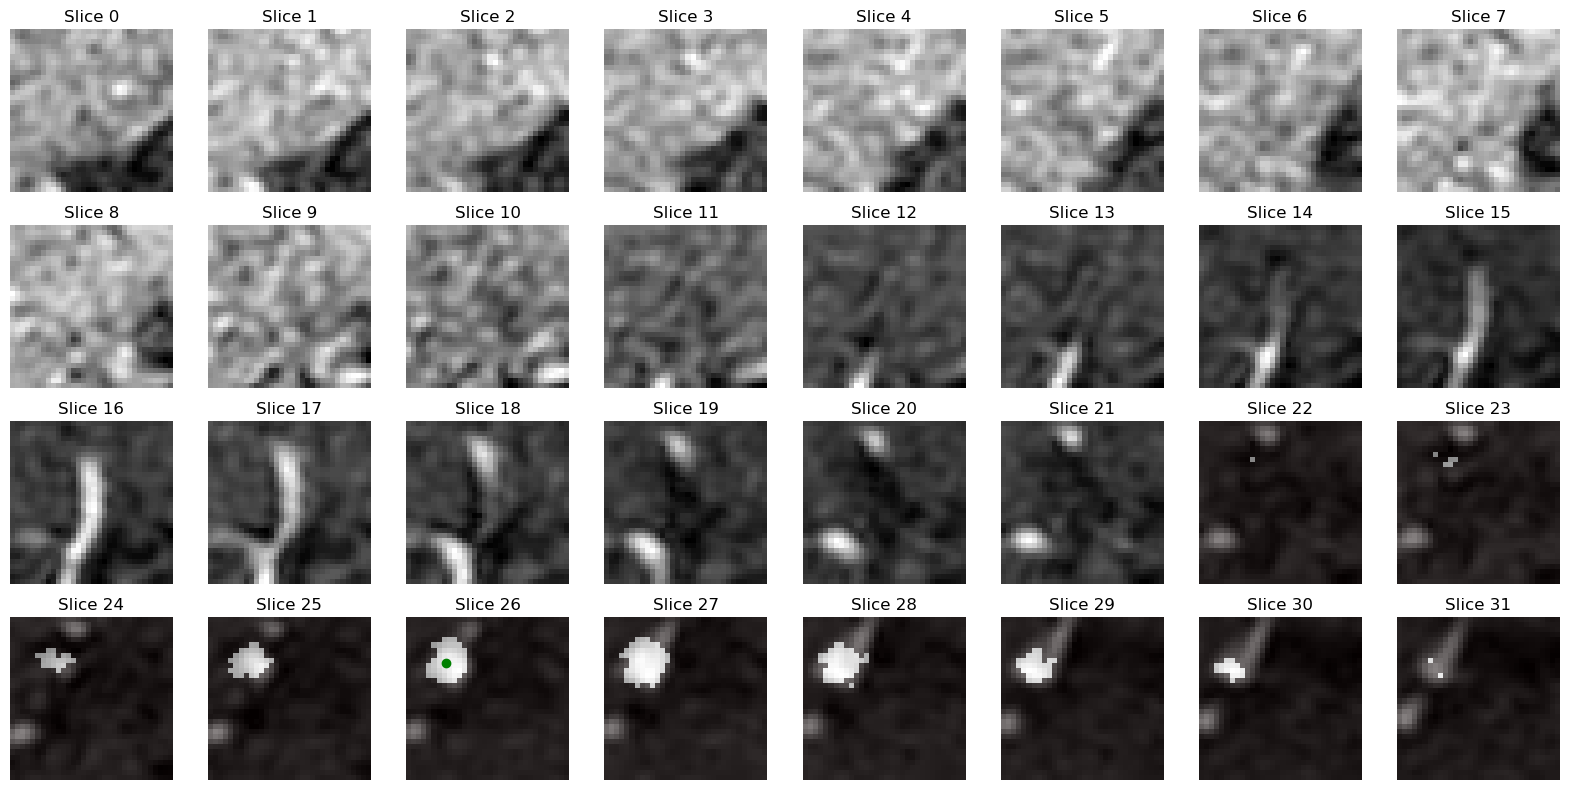

In [63]:
# Populate the mask with the aneurysm location based on the provided coordinates
for z, y, x in coords:
    mask[z, y, x] = 1

# Function to display slices with the centroid overlay
def show_slices_with_centroid(data, mask, centroid):
    num_slices = data.shape[0]
    cols = 8  # Number of slices per row
    rows = num_slices // cols + int(num_slices % cols != 0)  # Number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.flatten()

    # Loop through each slice
    for i in range(num_slices):
        axes[i].imshow(data[i, :, :], cmap='gray')
        if np.any(mask[i, :, :]):  # If there's anything to show in the mask
            axes[i].imshow(mask[i, :, :], cmap='hot', alpha=0.5)
            # If the centroid is within the current slice, display it
            if int(centroid[0]) == i:
                axes[i].plot(centroid[2], centroid[1], 'go')  # Mark the centroid with a green dot

        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')

    # Hide any remaining axes if there are fewer slices than subplots
    for i in range(num_slices, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# The 'coords' array is currently empty, we need the actual coordinates to proceed
# For now, let's simulate the centroid visualization with dummy data
# This is just a placeholder and will be replaced with the actual code once we have the coordinates
if coords.size > 0:
    show_slices_with_centroid(rotated_data, rotated_mask, centroid)
else:
    print("The 'coords' array is empty. Please provide the actual coordinates of the aneurysm.")

In [64]:
# Extracting the vessel direction from the rotated direction vector components
vessel_direction = rotated_direction[[1, 4, 7]]

# Now we need to find an arbitrary point on the plane perpendicular to this vessel_direction.
# To do this, we can use the cross product of the vessel_direction with two different basis vectors (e.g., [1, 0, 0] and [0, 1, 0]).
# This will yield vectors that are perpendicular to the vessel_direction.
# We can then translate these vectors to pass through the centroid of the aneurysm to get the actual perpendicular_vector.

# Choose basis vectors for creating a vector perpendicular to the vessel direction vector.
# If the vessel direction vector is not parallel to the x or y-axis, we can use [1, 0, 0] or [0, 1, 0].
basis_vector1 = np.array([1, 0, 0])
basis_vector2 = np.array([0, 1, 0])

# Calculate two vectors on the plane perpendicular to the vessel direction vector.
perpendicular_vector1 = np.cross(vessel_direction, basis_vector1)
perpendicular_vector2 = np.cross(vessel_direction, basis_vector2)

# Choose the perpendicular vector that is not zero in magnitude.
# A vector with zero magnitude indicates it is parallel to the vessel direction vector, so it cannot be used.
if norm(perpendicular_vector1) > 0:
    perpendicular_vector = perpendicular_vector1
else:
    perpendicular_vector = perpendicular_vector2

# Now we normalize the perpendicular_vector and translate it to pass through the centroid of the aneurysm.
# To select a point on the plane, we move one unit along this vector from the centroid of the aneurysm.
point_on_plane = centroid + perpendicular_vector / norm(perpendicular_vector)

# We can now calculate the vector that connects the centroid of the aneurysm to a point on the plane.
# This vector passes through the centroid of the aneurysm and is perpendicular to the vessel direction vector.
perpendicular_vector_through_centroid = point_on_plane - centroid
perpendicular_vector_through_centroid = perpendicular_vector_through_centroid / norm(perpendicular_vector_through_centroid)

print("perpendicular_vector_through_centroid:", perpendicular_vector_through_centroid)

perpendicular_vector_through_centroid: [0.         0.66436242 0.74741058]


In [65]:
# Calculate the normal to the plane defined by vessel_direction and perpendicular_vector
# This normal vector will be perpendicular to both vessel_direction and perpendicular_vector
plane_normal = np.cross(vessel_direction, perpendicular_vector_through_centroid)
plane_normal = plane_normal / norm(plane_normal)  # Normalize the vector

# Now we can define the plane with the normal vector and a point on the plane (the centroid)
# A plane is defined by the equation Ax + By + Cz + D = 0, where [A, B, C] is the plane normal
# and D can be found by plugging the point (centroid) into the plane equation
D = -plane_normal.dot(centroid)

# The plane equation is now defined as:
plane_equation = np.append(plane_normal, D)

print("Plane normal vector:", plane_normal)
print("Plane equation coefficients:", plane_equation)

Plane normal vector: [-0.98936807 -0.10869832  0.09662036]
Plane equation coefficients: [-0.98936807 -0.10869832  0.09662036 26.76391443]


In [66]:
# rotation axis (z-axis)
rotation_axis = np.array([0, 0, 1])

# calculate the rotate angle
cos_angle = np.dot(plane_normal, rotation_axis) / (norm(plane_normal) * norm(rotation_axis))
rotation_angle = np.arccos(cos_angle)

# rotation matrix based on the rotation axis and angle
rotation_vector = np.cross(plane_normal, rotation_axis)
rotation = R.from_rotvec(rotation_vector * rotation_angle)

result_data = rotate(rotated_data, angle=np.degrees(rotation_angle), axes=(1,2), reshape=False)
result_mask = rotate(rotated_mask, angle=np.degrees(rotation_angle), axes=(1,2), reshape=False)


show_all_slices(result_data)
show_all_slices(result_mask)
show_all_slices_with_overlay(result_data, result_mask)

In [67]:
# perform dynamic axis rotation
def dynamic_axis_rotation(data, mask, vessel_direction, centroid):
    """
    Perform dynamic axis rotation based on aneurysm direction and position.
    """
    # Define the basis vectors
    basis_vectors = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]
    
    # Find the closest basis vector to the aneurysm direction
    closest_basis = min(basis_vectors, key=lambda b: np.abs(np.dot(vessel_direction, b)))
    
    # Calculate the rotation angle and axis
    rotation_axis = np.cross(vessel_direction, closest_basis)
    if norm(rotation_axis) == 0:  # This means the vessel_direction and closest_basis are parallel
        # We can choose any axis perpendicular to vessel_direction for rotation
        rotation_axis = np.cross(vessel_direction, np.array([0, 0, 1]))
        rotation_axis = rotation_axis / norm(rotation_axis)  # Normalize the axis
    
    cos_angle = np.dot(vessel_direction, closest_basis) / (norm(vessel_direction) * norm(closest_basis))
    rotation_angle = np.arccos(cos_angle)

    # Perform the rotation
    result_data = rotate(data, angle=np.degrees(rotation_angle), axes=(1, 2), reshape=False)
    result_mask = rotate(mask, angle=np.degrees(rotation_angle), axes=(1, 2), reshape=False)

    return result_data, result_mask

result_data, result_mask = dynamic_axis_rotation(rotated_data, rotated_mask, vessel_direction, centroid)

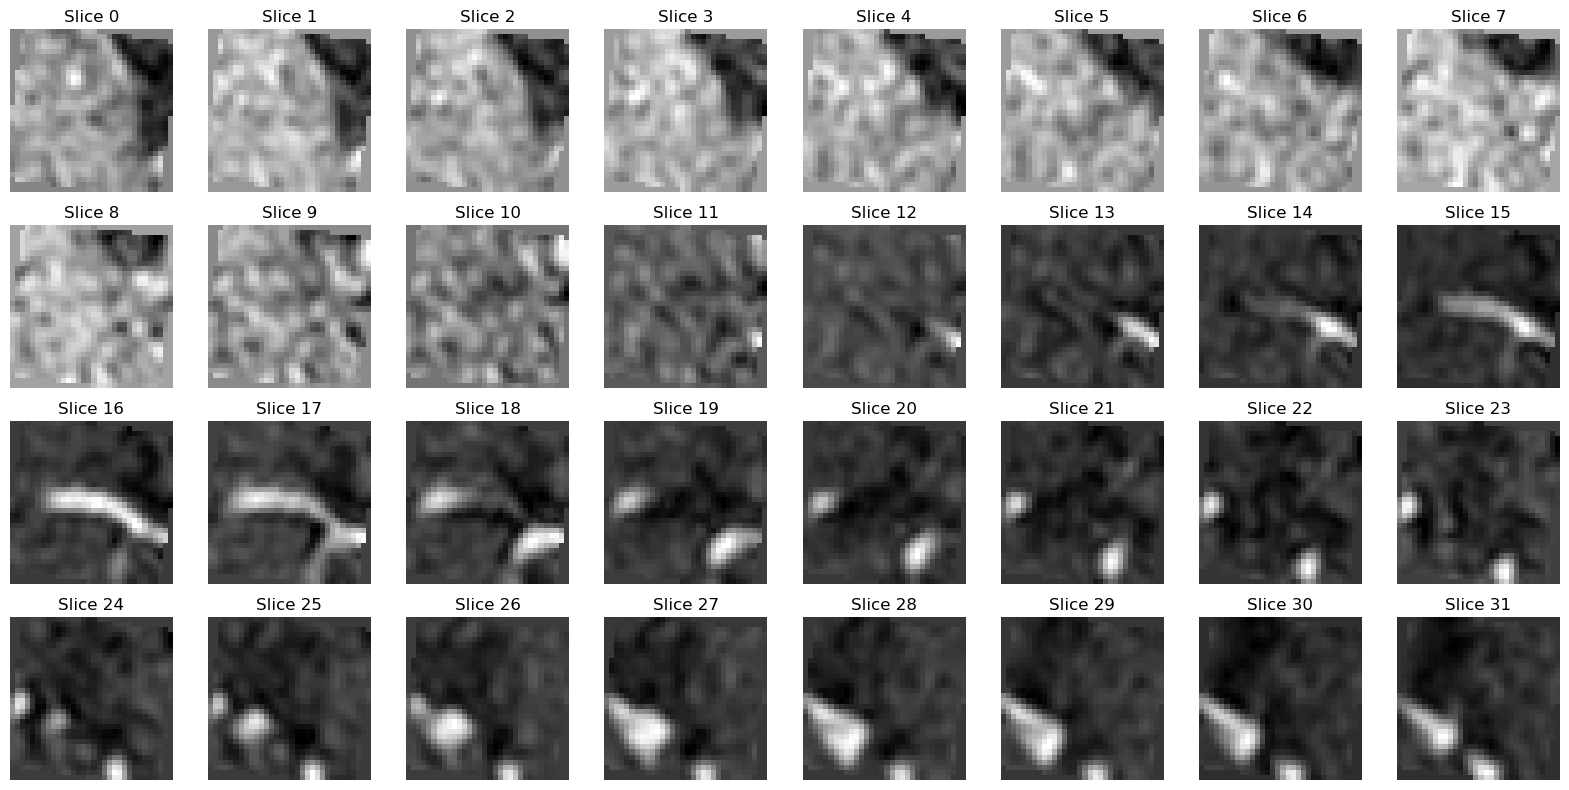

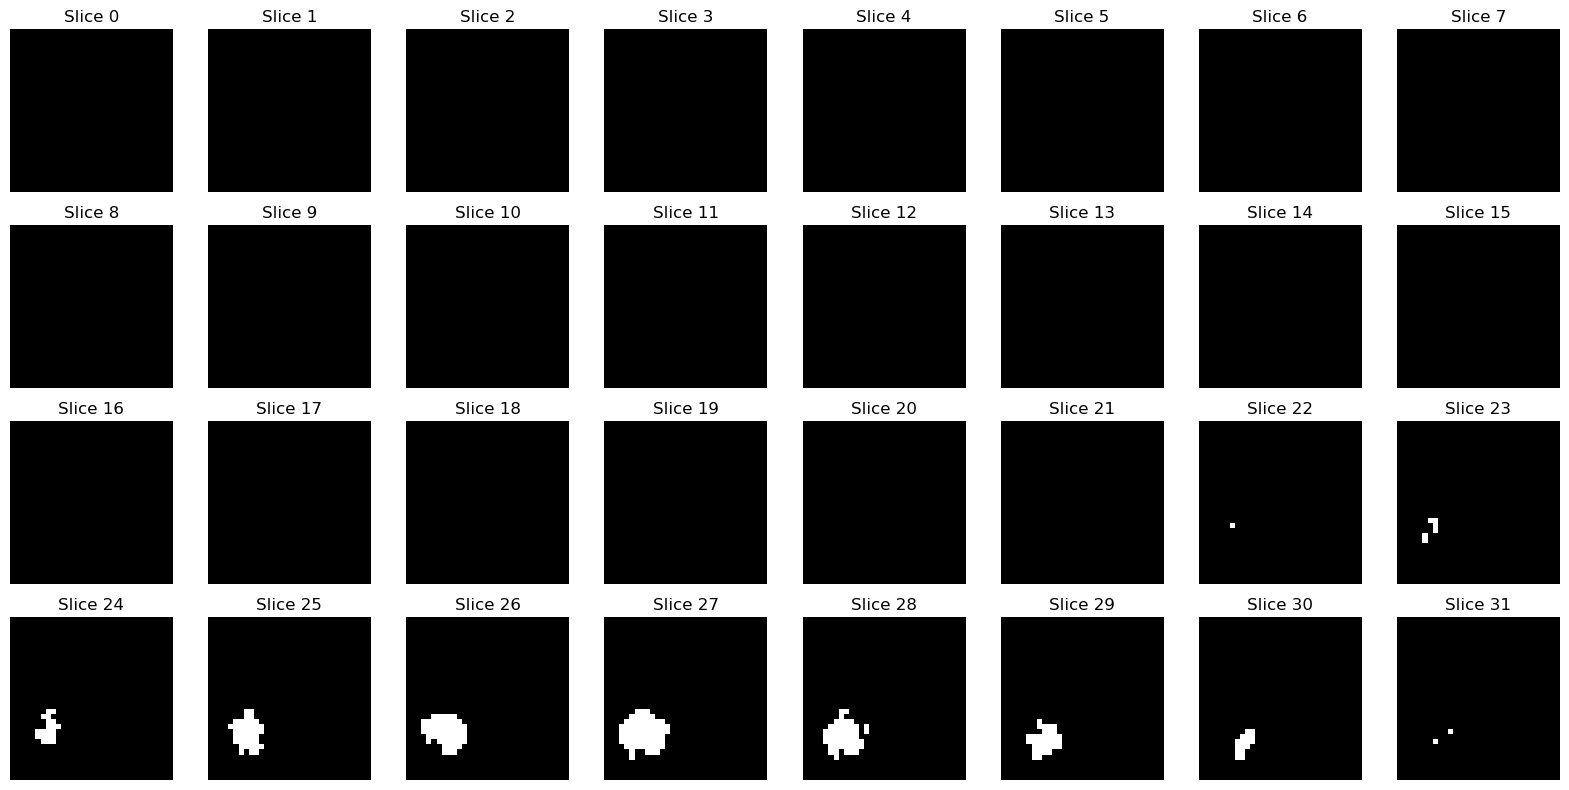

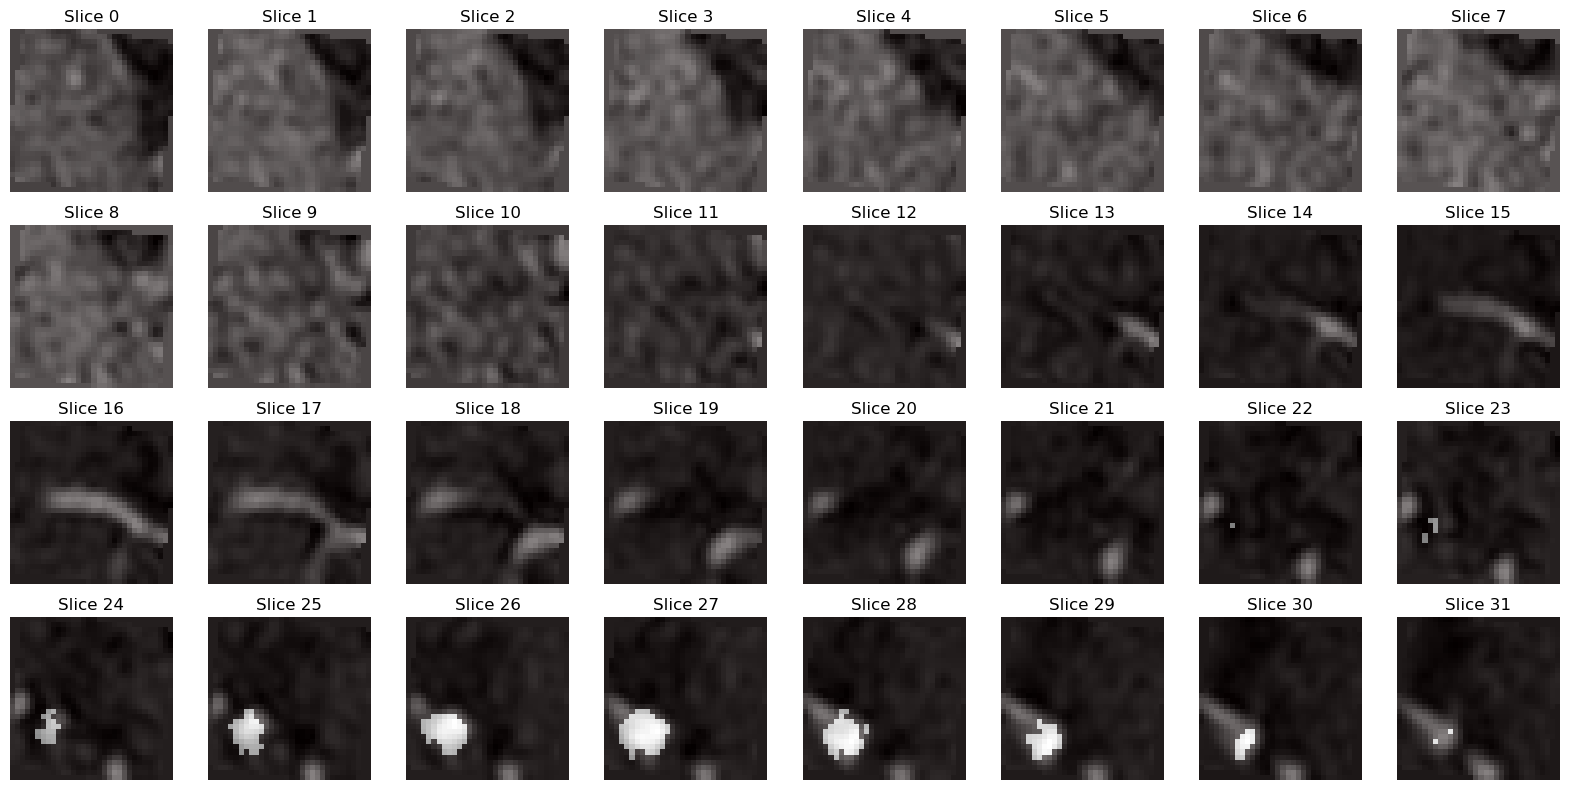

In [68]:
show_all_slices(result_data)
show_all_slices(result_mask)
show_all_slices_with_overlay(result_data, result_mask)

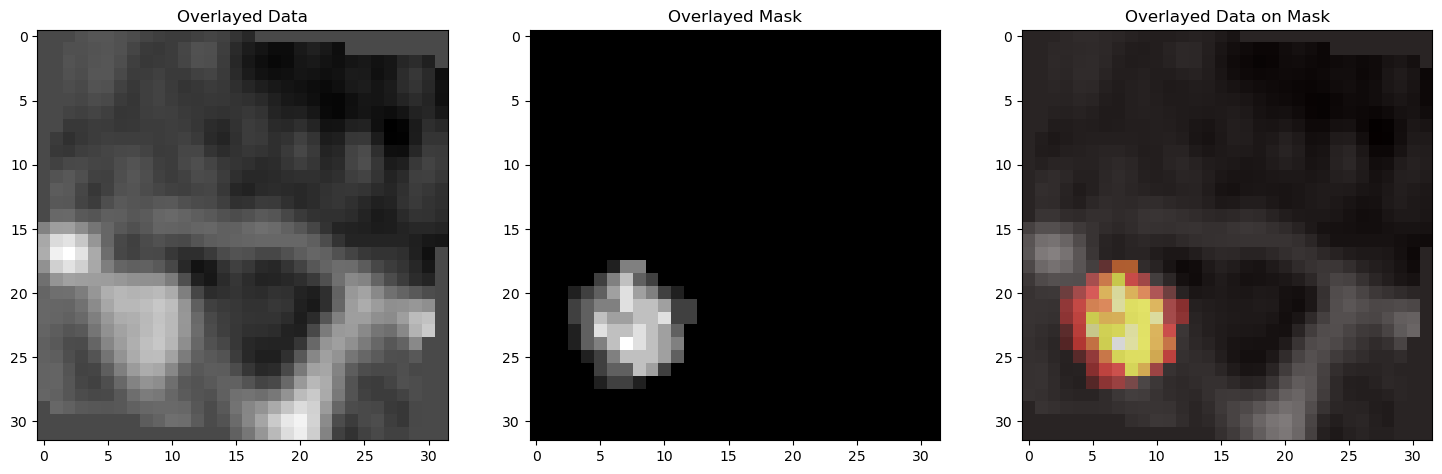

In [69]:
# overlayed result data, mask, and data on mask
overlayed_result_data, overlayed_result_mask, overlayed_result_data_on_mask = overlay_slices(result_data, result_mask, process_all_slices=True, average_slices=False)
visualize_overlay(overlayed_result_data, overlayed_result_mask, overlayed_result_data_on_mask)

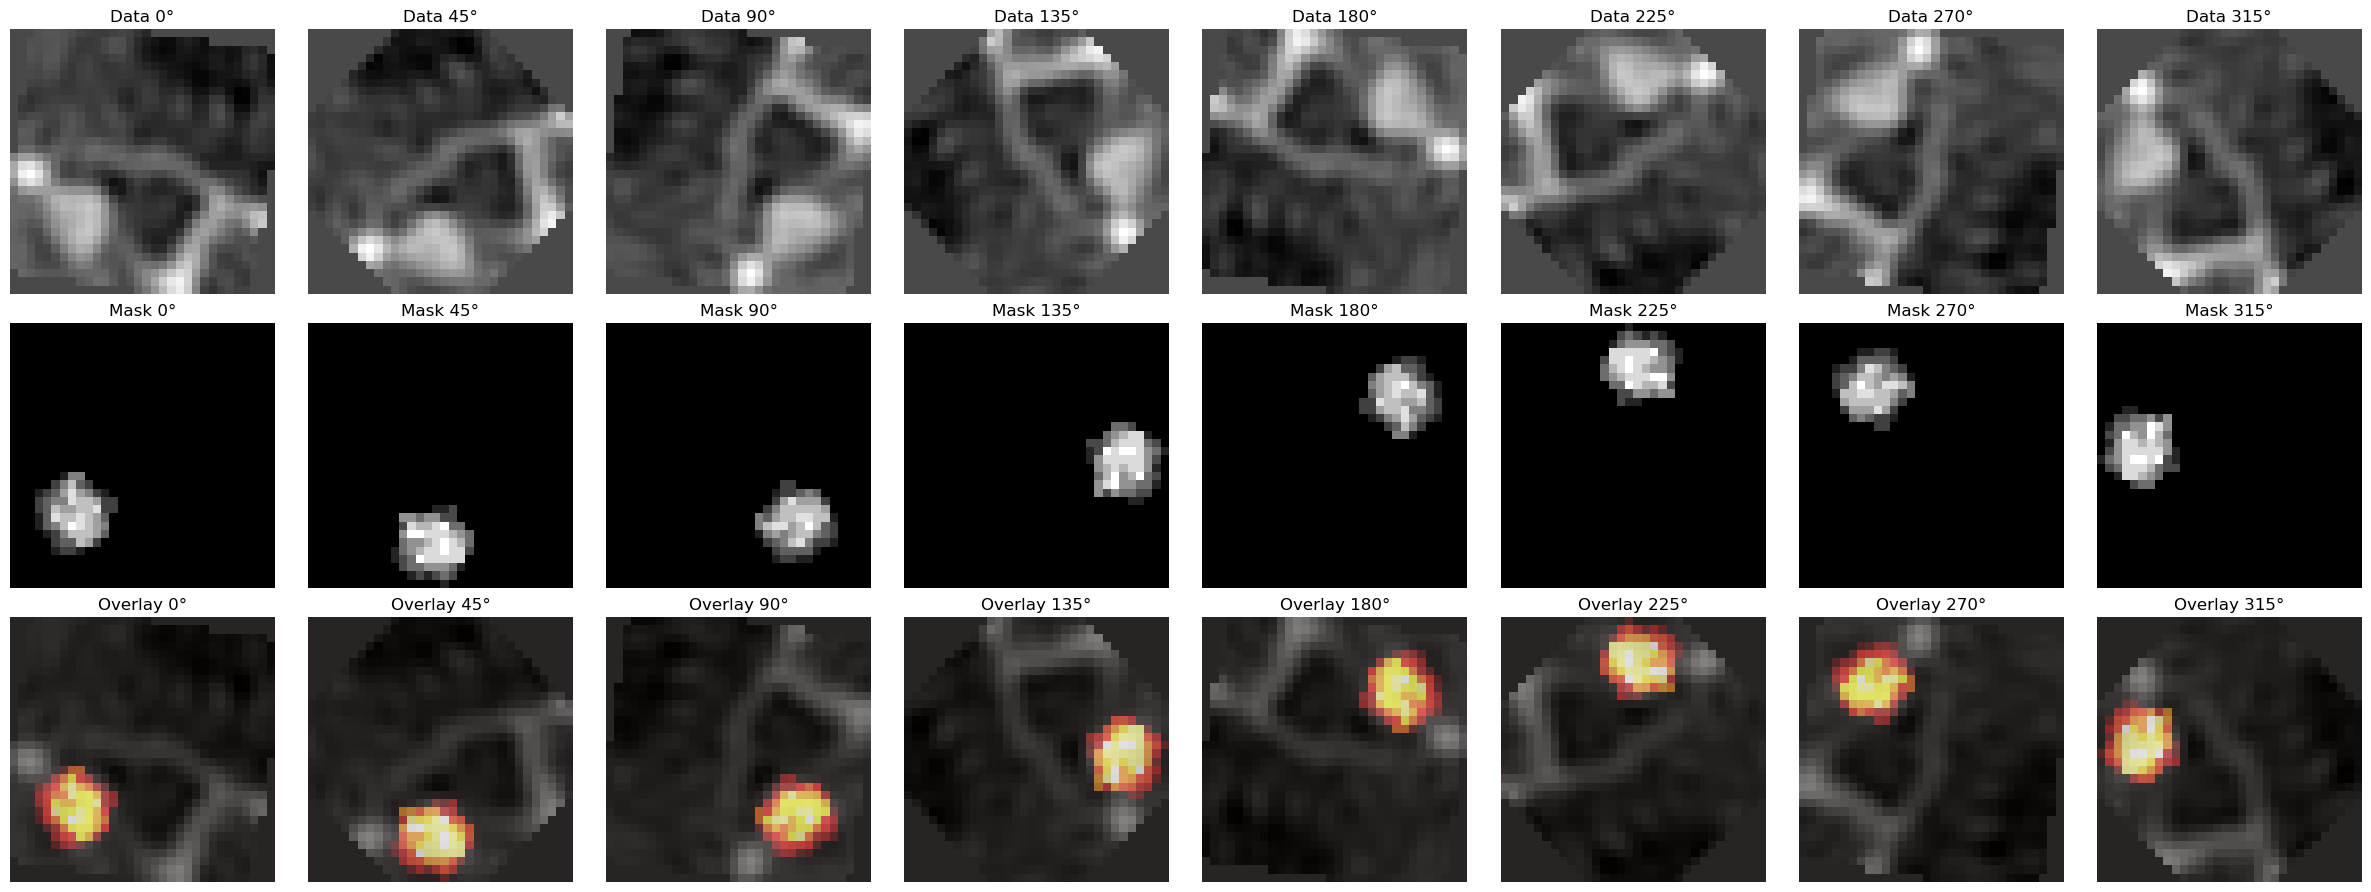

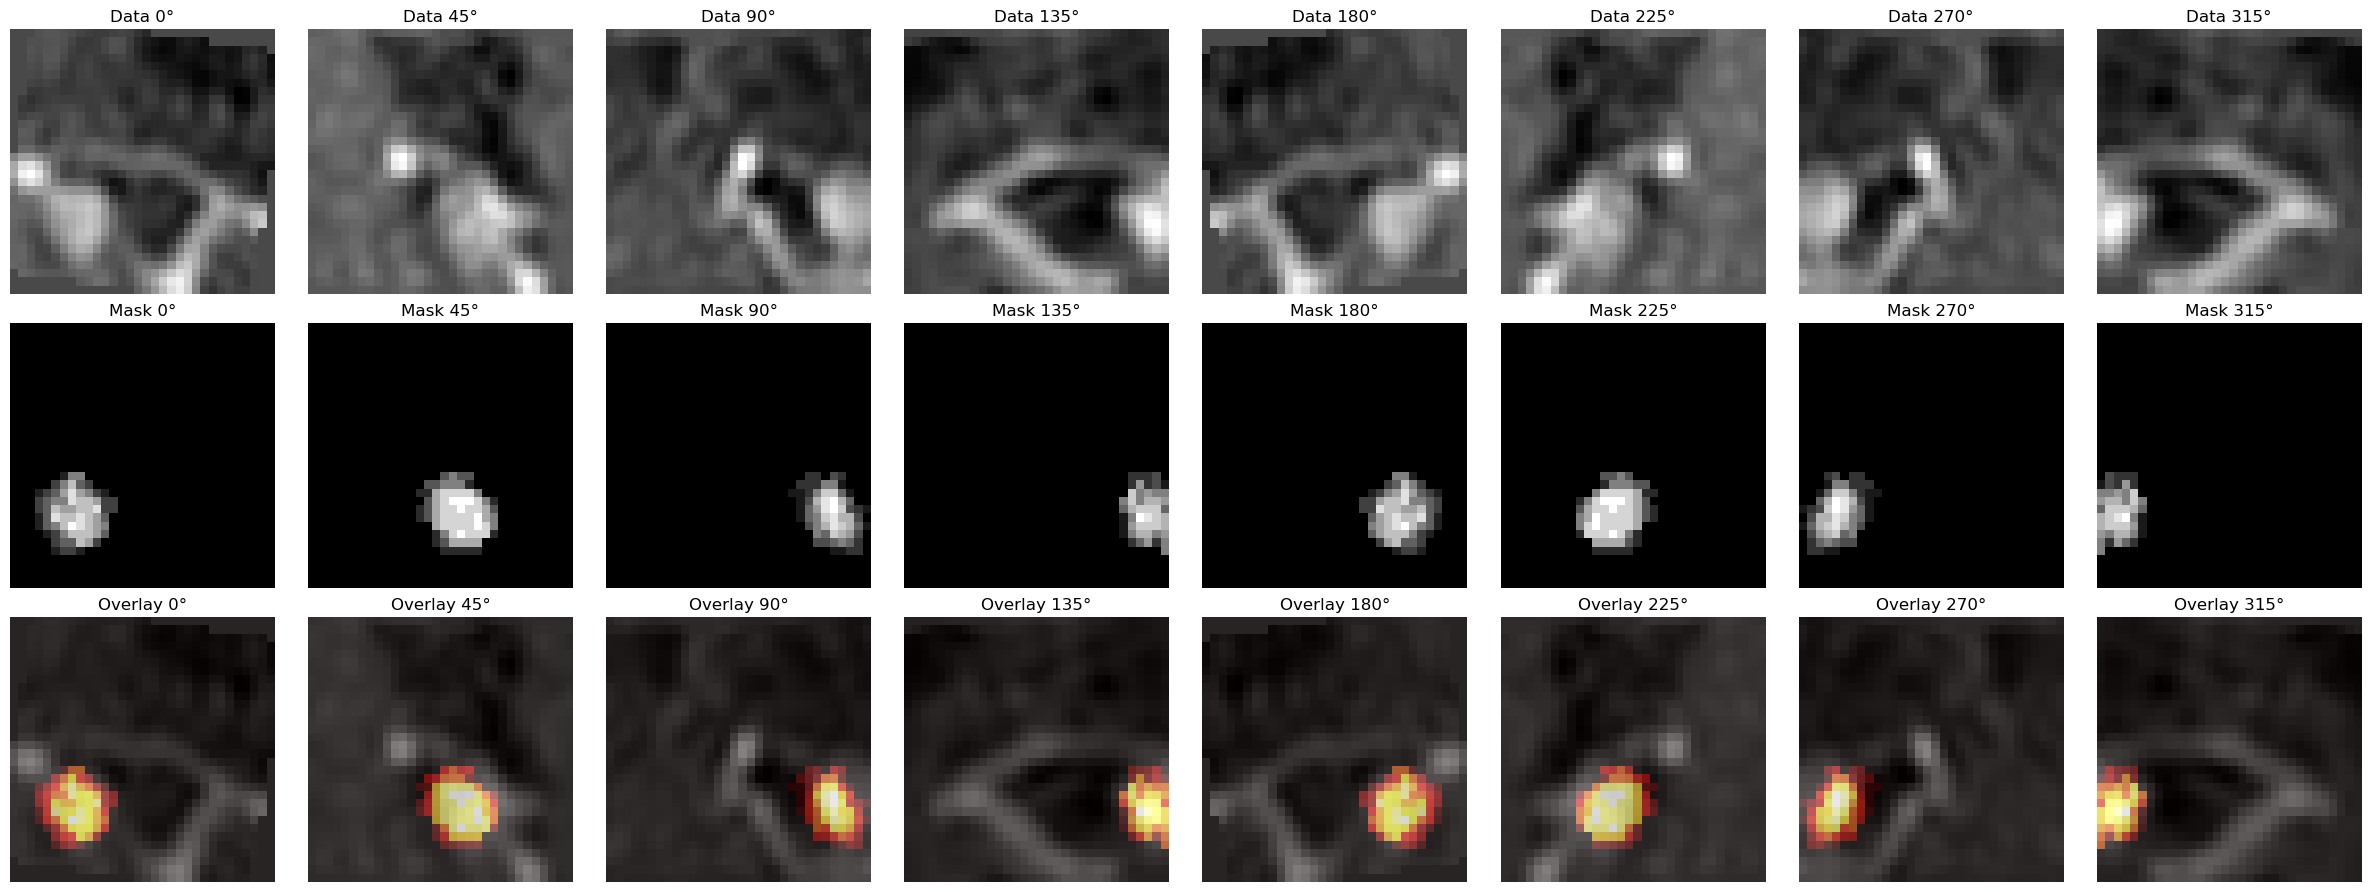

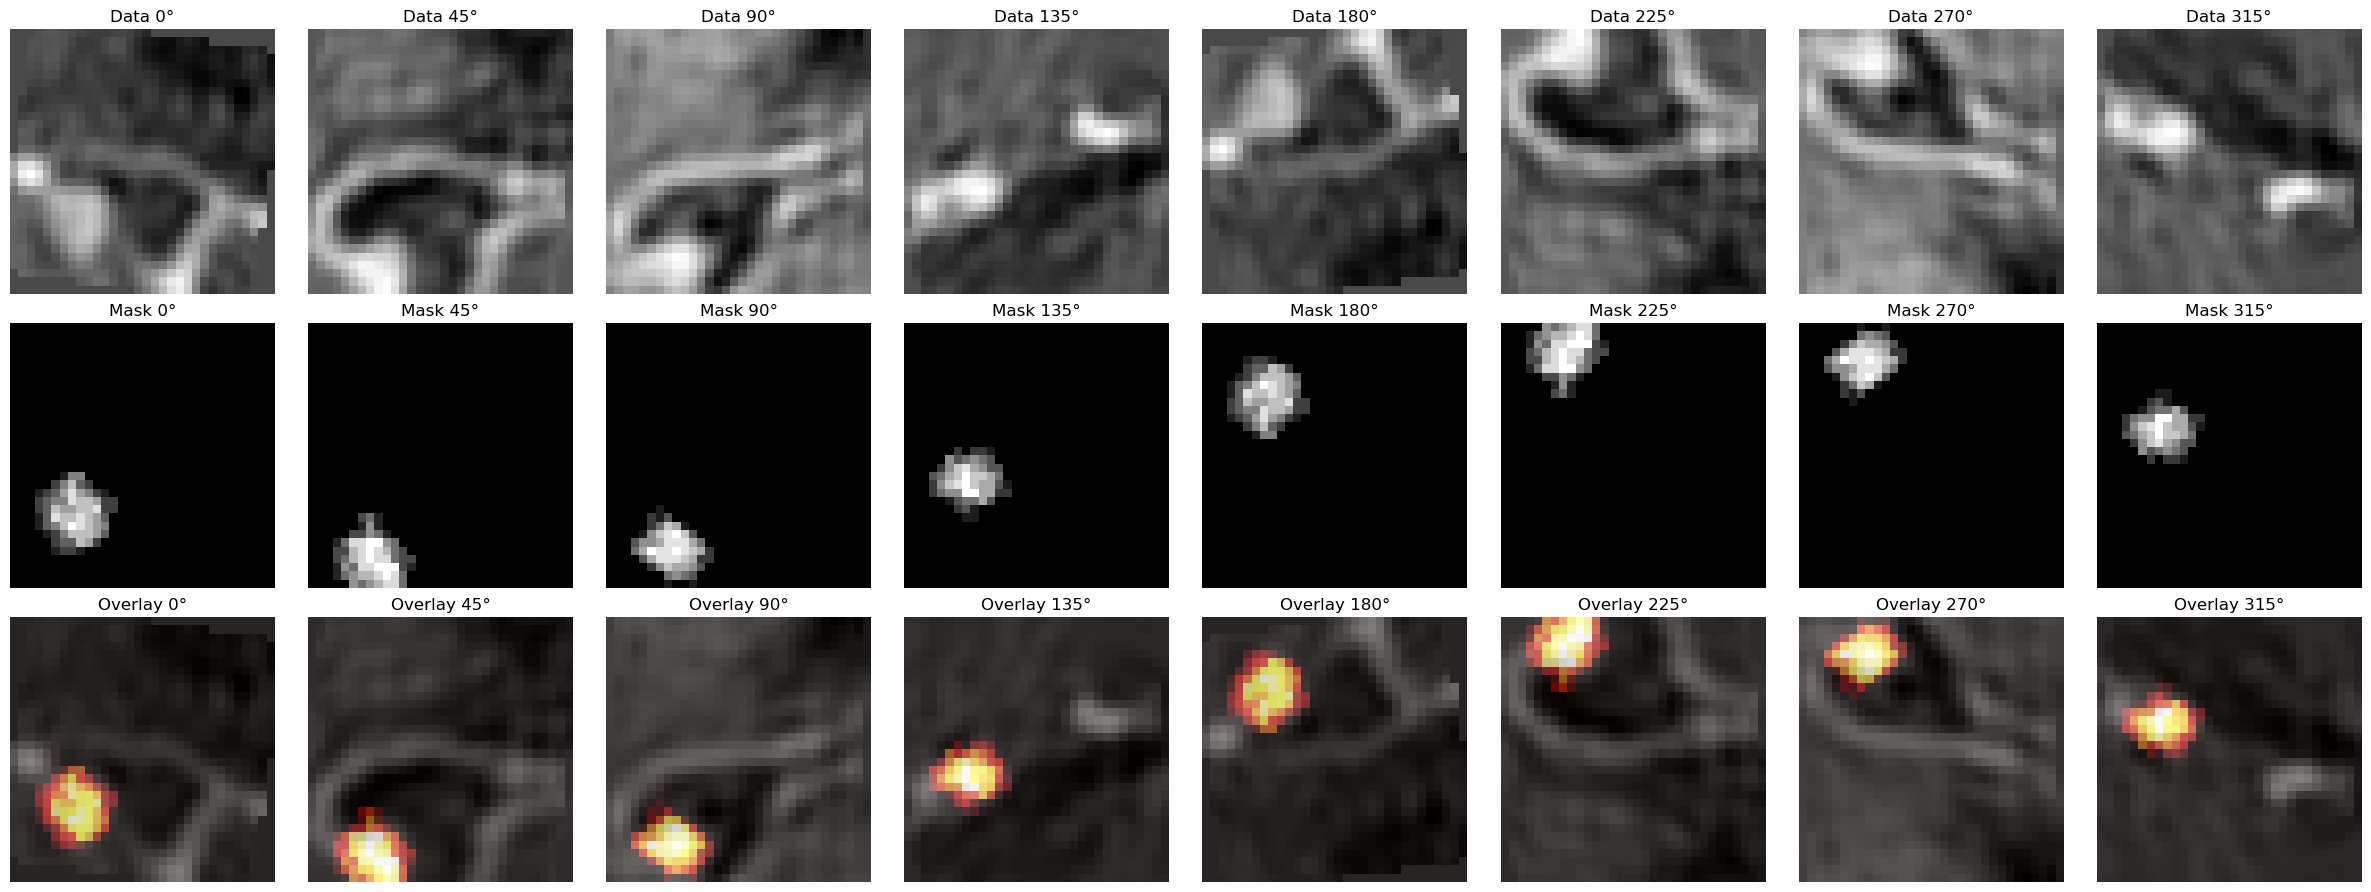

In [70]:
def rotate_and_overlay(data, mask, axis, angles, process_all_slices=True, average_slices=False):
    """
    Rotate data and mask around a given axis by each angle in angles and create overlays.
    Show all overlays for comparison.
    """
    n = len(angles)
    fig, axs = plt.subplots(3, n, figsize=(n * 3, 9))  # Adjust the size as needed

    for i, angle in enumerate(angles):
        # Rotate the data and mask
        rotated_data = rotate(data, angle, axes=axis, reshape=False)
        rotated_mask = rotate(mask, angle, axes=axis, reshape=False)

        # Get overlays
        overlayed_data, overlayed_mask, overlayed_data_on_mask = overlay_slices(rotated_data, rotated_mask,
                                                                                 process_all_slices, average_slices)
        
        # Visualize overlays
        axs[0, i].imshow(overlayed_data, cmap='gray')
        axs[0, i].set_title(f"Data {angle}°")
        axs[0, i].axis('off')

        axs[1, i].imshow(overlayed_mask, cmap='gray')
        axs[1, i].set_title(f"Mask {angle}°")
        axs[1, i].axis('off')

        axs[2, i].imshow(overlayed_data, cmap='gray', interpolation='none')
        axs[2, i].imshow(overlayed_mask, cmap='hot', alpha=0.5, interpolation='none')
        axs[2, i].set_title(f"Overlay {angle}°")
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Define the rotation angles you want to visualize
angles_to_rotate = [0, 45, 90, 135, 180, 225, 270, 315]

# rotation around x-axis (y-z plane)
axis_of_rotation_x = (1, 2)
rotate_and_overlay(result_data, result_mask, axis_of_rotation_x, angles_to_rotate)

# rotation around y-axis (x-z plane)
axis_of_rotation_y = (0, 2)
rotate_and_overlay(result_data, result_mask, axis_of_rotation_y, angles_to_rotate)

# rotation around z-axis (x-y plane)
axis_of_rotation_z = (0, 1)
rotate_and_overlay(result_data, result_mask, axis_of_rotation_z, angles_to_rotate)